# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import timedelta
from pandas.plotting import table

In [2]:
# import libraries for time series analysis and forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# Load dataset

In [3]:
ping_df = pd.read_json('./ping_dataset.json')

# Data Wrangling & Exploratory Analysis

In [4]:
ping_df.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program
3,2016-02-29,2016-02-29 08:00:03.129,11l0tD2wFPFO,False,None
4,2016-02-29,2016-02-29 08:00:03.610,56429432,False,None


In [5]:
ping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823567 entries, 0 to 4823566
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   timestamp  datetime64[ns]
 2   uid        object        
 3   isFirst    bool          
 4   utmSource  object        
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 151.8+ MB


We check for duplicate entries (rows) and observe that there are around 13,000 (~0.26% of total):

In [6]:
sum(ping_df.duplicated())

12979

We drop duplicates by keeping only the first entry in the dataset.

In [7]:
ping_df.drop_duplicates(inplace=True)

In [8]:
ping_df.describe(include='all',datetime_is_numeric=False)

/home/roberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/home/roberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,timestamp,uid,isFirst,utmSource
count,4810588,4810588,4810588,4810588,3142386
unique,29,4802369,246840,2,52
top,2016-02-29 00:00:00,2016-02-25 19:46:44.202000,vwLJO2uDWrXr,False,Biznesowe+Rewolucje
freq,194243,18,2807,4723945,1776600
first,2016-02-01 00:00:00,2016-02-01 08:00:01.230000,NaN,NaN,NaN
last,2016-02-29 00:00:00,2016-03-01 07:59:58.557000,NaN,NaN,NaN


We observe the following:
- 'date' does not seem to have missing values. There are 29 unique values, which should correspond to the 29 different days in February 2016 (leap year). First date is 2016-02-01 and last date is 2016-02-29 as expected.
- 'timestamp' does not seem to have missing values. Most values are unique but some have frequencies > 1. The first timestamp is 2016-02-01 at slightly after 8am, which is suspicious since we would expect pings to happen starting from midnight. Similarly, the last timestamp is 2016-03-01 right before 8am.
- 'uid' does not seem to have missing values. As expected, only a small subset is unique.
- 'isFirst' does not seem to have missing values. It is a boolean variable so only two unique values. As expected, greatly imbalanced towards False.
- 'utmSource' seems to have missing values and only 52 unique ones (expected since these are traffic sources).

We now analyze each feature separately in more detail.

### date
We can uncomment the following line and visually check that the 29 unique values indeed correspond to the 29 days of February 2016:

In [9]:
# sorted(ping_df['date'].unique())

We plot the distribution of the date column by each day of the month. We consistently observe decreasing number of pings on Fridays and Saturdays throughout the month with a repeating pattern. We also observe that there is an overall increasing trend over time.

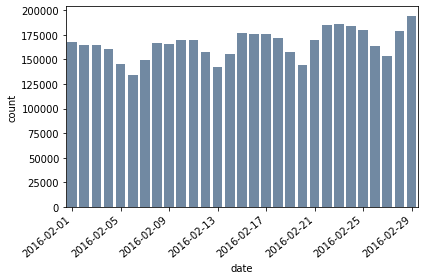

In [10]:
ax = sns.countplot(x='date', data=ping_df, color='#6989AA')

# make ticks on x-axis more readable by rotating the text and skipping some ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
day_ticks = [day.get_text() for day in ax.get_xticklabels()]
day_ticks_trimmed = [dt[:10] for dt in day_ticks]
plt.xticks(range(0,len(day_ticks_trimmed),4),day_ticks_trimmed[::4])

plt.tight_layout()
plt.show()

We observe that many entries (~1.2M) have a different date in the 'date' and 'timestamp' fields, which indicates a mistake since the date should be the same:

In [11]:
ping_df[ping_df['date'].apply(lambda x:x.day)!=ping_df['timestamp'].apply(lambda x:x.day)]

,date,timestamp,uid,isFirst,utmSource
145865,2016-02-29,2016-03-01 00:00:00.022,61025283,False,Biznesowe+Rewolucje
145866,2016-02-29,2016-03-01 00:00:00.361,jAWH3jsbYWII,False,Biznesowe+Rewolucje
145867,2016-02-29,2016-03-01 00:00:01.001,59527934,False,None
145868,2016-02-29,2016-03-01 00:00:02.004,59946862,False,None
145869,2016-02-29,2016-03-01 00:00:02.973,oeFioSLEv0Hc,False,None
...,...,...,...,...,...
4823561,2016-02-06,2016-02-07 07:59:55.524,Owrk6WHGQ0jS,False,None
4823562,2016-02-06,2016-02-07 07:59:55.890,QLECxJO2VaIZ,False,Biznesowe+Rewolucje
4823563,2016-02-06,2016-02-07 07:59:57.185,58056634,False,shmoop_left
4823564,2016-02-06,2016-02-07 07:59:57.629,56936469,False,None


For those entries with the date mismatch, the date in the 'date' field is always one day before the date in the 'timestamp' field:

In [12]:
(ping_df['date'].dt.date-ping_df['timestamp'].dt.date).value_counts()

0 days     3607230
-1 days    1203358
dtype: int64

We can also look at the distribution of times (e.g. hour of day) for the entries with the date mismatch:

In [13]:
# create dataframe containing only those entries
different_date_df = ping_df[ping_df['date'].apply(lambda x:x.day)!=ping_df['timestamp'].apply(lambda x:x.day)].copy()

# extract hour from 'timestamp'
different_date_df['timestamp_hour'] = different_date_df['timestamp'].dt.hour

# group by hour and look at counts for each hour
different_date_df.groupby('timestamp_hour').count()['timestamp']

timestamp_hour
0    184719
1    177036
2    171445
3    166603
4    141389
5    120498
6    113984
7    127684
Name: timestamp, dtype: int64

and we can do the same for the entries without the date mismatch:

In [14]:
same_date_df = ping_df[ping_df['date'].apply(lambda x:x.day)==ping_df['timestamp'].apply(lambda x:x.day)].copy()
same_date_df['timestamp_hour'] = same_date_df['timestamp'].dt.hour
same_date_df.groupby('timestamp_hour').count()['timestamp']

timestamp_hour
8     159052
9     156460
10    145957
11    166847
12    210098
13    275826
14    321895
15    325030
16    307555
17    276918
18    243861
19    224139
20    213127
21    202783
22    193223
23    184459
Name: timestamp, dtype: int64

This is really interesting! The date mismatch problem occurs for pings happening between midnight and 8am. We noticed previously that the recorded timestamps strangely started at 8am on Feb 1st and ended at 8am on Mar 1st. This seems to indicate a possible error in recording the time in the timestamps (maybe due to time zone conversions or conventions?), as if all timestamps had been shifted by 8 hours (so that the first pings actually happened at midnight on Feb 1st instead of 8am and, similarly, the last pings in the dataset happened on Feb 29th instead of Mar 1st between midnight and 8am). Based on this, we decide to subtract 8 hours from all times in the timestamp column:

In [15]:
ping_df['timestamp'] = pd.to_datetime(ping_df['timestamp']) - timedelta(hours=8)

We verify that now, as expected, dates in the 'date' and 'timestamp' columns match and there are no mismatches:

In [16]:
sum(ping_df['date'].apply(lambda x:x.day)!=ping_df['timestamp'].apply(lambda x:x.day))

0

### timestamp
We observe that around 7,000 timestamps appear more than once. While it is possible that two pings happen exactly at the same time, it seems unlikely to have many such occurrences, since timestamps are recorded with a millisecond-level precision. This needs additional investigation as to understand whether the pings associated to these timestamps have something special or unusual in common (day or traffice source, for instance). Many simultaneous pings might be an indication of fraudolent networks or activities such as click spamming.

In [17]:
ping_timestamp_vc = ping_df['timestamp'].value_counts()
ping_timestamp_vc[ping_timestamp_vc>1]

2016-02-25 11:46:44.202    18
2016-02-24 12:14:41.723    17
2016-02-24 11:21:37.756    17
2016-02-25 12:02:29.591    17
2016-02-25 09:59:28.988    17
                           ..
2016-02-17 06:25:29.203     2
2016-02-01 06:30:30.088     2
2016-02-17 05:56:17.483     2
2016-02-16 07:57:06.929     2
2016-02-12 01:24:39.712     2
Name: timestamp, Length: 7247, dtype: int64

In [18]:
# create list of timestamps with count>1
non_unique_timestamps_list = list(ping_timestamp_vc[ping_timestamp_vc>1].index)

In [19]:
# create dataframe containing only those timestamps for further investigation
non_unique_timestamps_ping_df = ping_df[ping_df['timestamp'].isin(non_unique_timestamps_list)]

A quick check is to plot an histogram of the milliseconds recorded for the timestamps. We expect a uniform distribution over the range [0,999]:

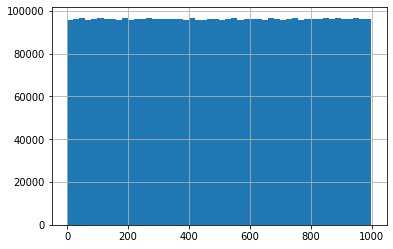

In [20]:
ping_df['timestamp'].apply(lambda x:pd.to_datetime(x).microsecond/1000).hist(bins=50)

Since the distribution looks uniform, we can assume that the timestamps are indeed recorded with millisecond precision. A non-uniform distribution would have indicated the presence of some strange pattern in how timestamps are recorded. This also substantiates the need for further investigation on frequent timestamps. Their distribution is non uniform, as expected:

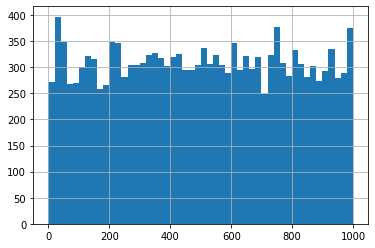

In [21]:
non_unique_timestamps_ping_df['timestamp'].apply(lambda x:pd.to_datetime(x).microsecond/1000).hist(bins=50)

Finally, we can look at the distribution of the times in the 'timestamp' column, for instance by hour of day:

In [22]:
# extract hour from 'timestamp'
ping_df['timestamp_hour'] = ping_df['timestamp'].dt.hour

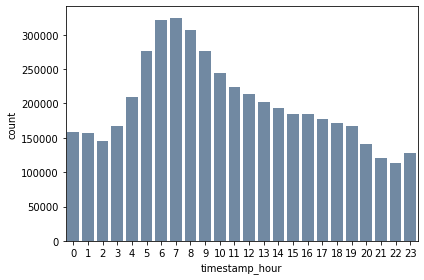

In [23]:
ax = sns.countplot(x='timestamp_hour', data=ping_df, color='#6989AA')
plt.tight_layout()
plt.show()

This is another interesting plot, as it shows that the times with the most pings are between 6-8am. Without additional information on what the app is used for, what reference time zone is used to record timestamps, and whether users open the app from only one or multiple time zones, it is hard to understand why the peak hours are 6-8am. However, under the assumptions that 1. the reference time zone in the dataset is US Pacific Time, 2. users open the app from around the world, and 3. the app is used for work-related tasks, a plot like this would certainly make sense, as 6-8am PT is 9-11am ET and 3-5pm in Central Europe, which are peak working hours.

### uid
We observe around 180,000 registered users (purely numeric uid):

In [24]:
sum([str(elem).isnumeric() for elem in list(ping_df['uid'].unique())])

180009

We create a boolean 'registered_user' column for later convenience.

In [25]:
ping_df['registered_user'] = ping_df['uid'].apply(lambda x:str(x).isnumeric())

### isFirst
We check the distribution of True and False and observe that it is highly imbalanced (as expected).

In [26]:
ping_df['isFirst'].value_counts()/len(ping_df['isFirst'])

False    0.981989
True     0.018011
Name: isFirst, dtype: float64

Each 'uid' should have at most one instance of isFirst=True in the dataset (an uid could have zero instances of isFirst=True if its first ping ever was before February 2016). We observe that for 45 'uid' this is not the case.

In [27]:
sum(ping_df[['uid','isFirst']].groupby(['uid']).sum()['isFirst']>1.0)

45

In [28]:
# create grouped dataframe with isFirst count for each 'uid'
isFirst_count_ping_df = ping_df[['uid','isFirst']].groupby(['uid']).sum().reset_index()

In [29]:
# create list of 'uid' that have more than one isFirst=True
double_isFirst_uid_list = list(isFirst_count_ping_df[isFirst_count_ping_df['isFirst']>1.0]['uid'])

Dataframe containing only uid that have more than one isFirst=True. This needs to be investigated. One way to fix these entries in the dataset would be to change the later entry to isFirst=False.

In [30]:
# create datagrame with double isFirst=True entries
double_isFirst_df = ping_df[ping_df['uid'].isin(double_isFirst_uid_list) & ping_df['isFirst']][['uid','timestamp']]

We can compute and plot the time difference (in seconds) between the two isFirst=True pings for each uid:

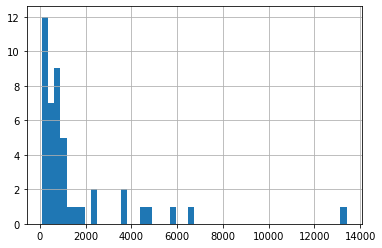

In [31]:
# compute time difference between the two isFirst=True pings for each uid
double_isFirst_df['diff']=double_isFirst_df.groupby(['uid']).diff()

# plot histogram of time differences between the two isFirst=True pings
double_isFirst_df[double_isFirst_df['diff'].notnull()]['diff'].astype('timedelta64[s]').hist(bins=50)
plt.show()

Similarly, 'isFirst'=True should by definition correspond to the minimum timestamp for that user. For 44 'uid' this is not the case.

In [32]:
# create list of 'uid' with isFirst=True
isFirst_uid_list = list(ping_df[ping_df['isFirst']]['uid'].unique())

In [33]:
# create dataframe with minimum timestamp and timestamp corresponding to isFirst=True
timestamp_comparison_df = ping_df[ping_df['uid'].isin(isFirst_uid_list)].groupby(['uid']).agg({'timestamp':'min'}).reset_index().merge(ping_df[ping_df['isFirst']],on=['uid'])

In [34]:
# 'uid' for which minimum timestamp != timestamp with isFirst=True (and that do not belong to double isFirst=True group)
timestamp_comparison_df[(timestamp_comparison_df['timestamp_x']!=timestamp_comparison_df['timestamp_y']) & ~timestamp_comparison_df['uid'].isin(double_isFirst_uid_list)].head()

,uid,timestamp_x,date,timestamp_y,isFirst,utmSource,timestamp_hour,registered_user
3760,50569954,2016-02-23 09:52:13.091,2016-02-23,2016-02-23 11:16:44.764,True,Biznesowe+Rewolucje,11,True
3765,50571665,2016-02-23 09:52:13.091,2016-02-23,2016-02-23 11:16:44.764,True,Biznesowe+Rewolucje,11,True
4032,50707349,2016-02-14 13:30:32.080,2016-02-14,2016-02-14 13:52:46.586,True,None,13,True
6349,52010378,2016-02-23 09:52:13.091,2016-02-23,2016-02-23 11:16:44.764,True,Biznesowe+Rewolucje,11,True
6583,52132056,2016-02-01 11:27:09.629,2016-02-01,2016-02-01 11:31:17.773,True,None,11,True


In [35]:
len(timestamp_comparison_df[(timestamp_comparison_df['timestamp_x']!=timestamp_comparison_df['timestamp_y']) & ~timestamp_comparison_df['uid'].isin(double_isFirst_uid_list)])

44

### utmSource
By uncommenting the following line we can observe that there are some duplicate sources with different spellings (e.g. facebook vs facebook.com vs Facebook_org). We also know that this field has missing values (=None).

In [36]:
# sorted(ping_df[ping_df['utmSource'].notnull()]['utmSource'].unique())

We put categories together when it is obvious that they represent the same source. More work could be done to understand whether other sources can be put together.

In [37]:
ping_df['utmSource'].replace({'Twitter_org':'twitter',
                              'facebook.com':'facebook','Facebook_org':'facebook',
                              'Blog_org':'blog',
                              'shmoop_left':'shmoop','shmoop_logo':'shmoop','shmoop_right':'shmoop'},inplace=True)

Most 'uid' have only one traffic source, but 60 have two. This needs to be investigated further.

In [38]:
ping_df.groupby(['uid']).agg({'utmSource':'nunique'})['utmSource'].value_counts()

1    147677
0     99103
2        60
Name: utmSource, dtype: int64

# Daily Active Users
We track and measure DAUs for each day in February 2016.

In [39]:
# group by date and count unique uid for each day
DAU_df = ping_df.groupby(['date']).agg({'uid': 'nunique'}).reset_index()

In [40]:
# group by date and count unique registered uid for each day
DAU_registered_df = ping_df[ping_df['registered_user']].groupby(['date']).agg({'uid': 'nunique'}).reset_index()

In [41]:
# merge dataframes on date
DAU_df = DAU_df.merge(DAU_registered_df,on='date')
DAU_df.rename({'uid_x':'total_DAU','uid_y':'registered_DAU'},axis=1,inplace=True)
DAU_df['registered_ratio'] = DAU_df['registered_DAU']/DAU_df['total_DAU']

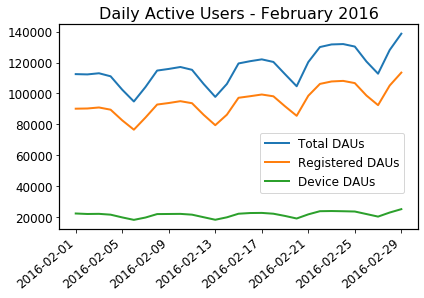

In [42]:
# plot daily active users over the month
fig, ax = plt.subplots()

DAU_df_dates = DAU_df['date'].apply(lambda x:str(x)[:10])
ax.plot(DAU_df_dates, DAU_df['total_DAU'], label='Total DAUs', linewidth=2.0)
ax.plot(DAU_df_dates, DAU_df['registered_DAU'], label='Registered DAUs', linewidth=2.0)
ax.plot(DAU_df_dates, DAU_df['total_DAU']-DAU_df['registered_DAU'], label='Device DAUs', linewidth=2.0)

ax.legend(fontsize=12,bbox_to_anchor=(0.98,0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xticks(range(0,len(day_ticks_trimmed),4),day_ticks_trimmed[::4])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
plt.tight_layout()
plt.title('Daily Active Users - February 2016', fontdict = {'fontsize':16})
plt.savefig('./plots/DAU_plot.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [43]:
DAU_df

,date,total_DAU,registered_DAU,registered_ratio
0,2016-02-01,112504,90146,0.801269
1,2016-02-02,112317,90276,0.803761
2,2016-02-03,113062,90931,0.804258
3,2016-02-04,111098,89500,0.805595
4,2016-02-05,102420,82596,0.806444
5,2016-02-06,94807,76566,0.807599
6,2016-02-07,104175,84426,0.810425
7,2016-02-08,114802,92824,0.808557
8,2016-02-09,115859,93816,0.809743
9,2016-02-10,117113,95003,0.811208


# Cohort-Based Retention Curves
We track daily cohort-based retention curves for selected dates.

In [44]:
def daily_retention_curve(start_date,ping_df):
    
    # cohort of uid with first ping on selected date
    cohort_uid = set(ping_df[(ping_df['date']==start_date) & ping_df['isFirst']]['uid'])
    
    # for cohort uid and dates after selected date, group by timestamp_date and count unique cohort uid for each day
    daily_retention_df = ping_df[(ping_df['date']>=start_date) & ping_df['uid'].isin(cohort_uid)].groupby('date').agg({'uid': 'nunique'}).reset_index()
    daily_retention_df.rename({'uid':'% of Users'},axis=1,inplace=True)
                      
    # normalize to obtain percentages                  
    daily_retention_df['% of Users']=100*daily_retention_df['% of Users']/len(cohort_uid)

    # create ticks for plot x-axis as Day 0, Day 1, ... from selected date                  
    rescaled_dates = ['Day ' + str((pd.to_datetime(date)-pd.to_datetime(start_date)).days) for date in daily_retention_df['date']]

    return len(cohort_uid),rescaled_dates,daily_retention_df

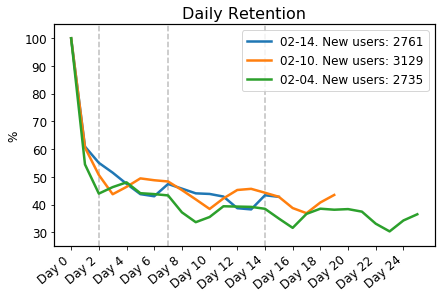

In [45]:
# plot daily retention curves
start_dates=sorted(['2016-02-04','2016-02-10','2016-02-14'], reverse=True)

fig, ax = plt.subplots()

for start_date in start_dates:
    cohort_size,rescaled_dates,daily_retention_df = daily_retention_curve(start_date,ping_df)
    legend_label=start_date[5:] + '. New users: ' + str(cohort_size)
    
    ax.plot(rescaled_dates, daily_retention_df['% of Users'],  linewidth=2.5, label=legend_label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.xticks(range(0,len(rescaled_dates),2),rescaled_dates[::2])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax.vlines(['Day 2','Day 7','Day 14'], 0, 1, transform=ax.get_xaxis_transform(), linestyle='dashed', color='0.75')
ax.set_ylim([25,105])
ax.legend(fontsize=12,bbox_to_anchor=(1.0,1.0))    
plt.tight_layout()
plt.title('Daily Retention', fontdict = {'fontsize':16})
plt.ylabel('%', fontsize=12)
plt.savefig('./plots/DR_plot.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [46]:
# display the retention curve dataframe
cohort_size,rescaled_dates,daily_retention_df = daily_retention_curve('2016-02-04',ping_df)
daily_retention_df

,date,% of Users
0,2016-02-04,100.000000
1,2016-02-05,54.478976
2,2016-02-06,43.948812
3,2016-02-07,46.288848
4,2016-02-08,48.007313
5,2016-02-09,44.095064
6,2016-02-10,43.765996
7,2016-02-11,43.290676
8,2016-02-12,37.184644
9,2016-02-13,33.638026


In [47]:
# display the retention curve dataframe
cohort_size,rescaled_dates,daily_retention_df = daily_retention_curve('2016-02-10',ping_df)
daily_retention_df

,date,% of Users
0,2016-02-10,100.000000
1,2016-02-11,60.562480
2,2016-02-12,50.687120
3,2016-02-13,43.720038
4,2016-02-14,46.372643
5,2016-02-15,49.440716
6,2016-02-16,48.769575
7,2016-02-17,48.322148
8,2016-02-18,45.222116
9,2016-02-19,41.866411


In [48]:
# display the retention curve dataframe
cohort_size,rescaled_dates,daily_retention_df = daily_retention_curve('2016-02-14',ping_df)
daily_retention_df

,date,% of Users
0,2016-02-14,100.000000
1,2016-02-15,60.919957
2,2016-02-16,55.052517
3,2016-02-17,51.503079
4,2016-02-18,47.482796
5,2016-02-19,43.752264
6,2016-02-20,42.991670
7,2016-02-21,47.410359
8,2016-02-22,45.744296
9,2016-02-23,44.042014


# Analysis of Traffic Sources
I know that the 'utmSource' field has approx 35% missing values. I exclude rows with missing traffic source from the following analysis.

### Median number of pings per user by traffic source

In [49]:
# create dataframe with number of pings per user by traffic source
pings_per_user_by_source_df = ping_df[ping_df['utmSource'].notnull()].groupby(['utmSource','uid']).count()['timestamp'].reset_index()
pings_per_user_by_source_df.rename({'timestamp':'number_of_pings'},axis=1,inplace=True)

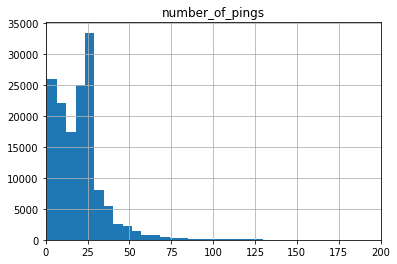

In [50]:
# plot distribution of number of pings per user
pings_per_user_by_source_df.hist(bins=500)
plt.xlim((0,200))
plt.show()

In [51]:
# create dataframe with median number of pings per user by traffic source and count of users by traffic source
median_pings_per_user_by_source_df = pings_per_user_by_source_df.groupby(['utmSource']).agg(MedianNumPingsPerUser=('number_of_pings', 'median'), NumUsers=('number_of_pings', 'count')).reset_index()

In [52]:
# keep only sources with at least 100 unique users and display metric in descending order
median_pings_per_user_by_source_df[median_pings_per_user_by_source_df['NumUsers']>=100].sort_values(by=['MedianNumPingsPerUser'],ascending=False)

,utmSource,MedianNumPingsPerUser,NumUsers
43,tapjoy,29.0,347
45,youtube,27.0,458
39,salesmanago,26.5,1122
22,contenthub,25.0,182
4,Grub+Street,24.0,2431
41,shmoop,24.0,6915
44,twitter,23.0,5152
27,facebook,23.0,140
37,program,22.0,16493
5,Just-In-Time+Travels+Newsletter,21.0,515


In [53]:
# format final dataframe for report
median_pings_per_user_by_source_df = median_pings_per_user_by_source_df[median_pings_per_user_by_source_df['NumUsers']>=100].sort_values(by=['MedianNumPingsPerUser'],ascending=False)
median_pings_per_user_by_source_df.drop(['NumUsers'],axis=1,inplace=True)
median_pings_per_user_by_source_df.reset_index(drop=True,inplace=True)
median_pings_per_user_by_source_df['MedianNumPingsPerUser'] = median_pings_per_user_by_source_df['MedianNumPingsPerUser'].apply(lambda x:int(x))
median_pings_per_user_by_source_df.rename({'utmSource':'Traffic Source','MedianNumPingsPerUser':'Median Number of Pings Per User'},axis=1,inplace=True)

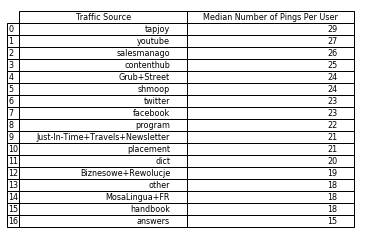

In [54]:
# save dataframe as figure for report
fig, ax = plt.subplots() 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)

tab = table(ax, median_pings_per_user_by_source_df, loc='upper right')  
tab.auto_set_font_size(False)
tab.set_fontsize(8)
plt.savefig('./plots/MNPPU_Table.png', bbox_inches='tight', dpi=300)

### Median number of active days per user by traffic source

In [55]:
# create dataframe with number of active days per user by traffic source
active_days_per_user_by_source_df = ping_df[ping_df['utmSource'].notnull()].groupby(['utmSource','uid']).agg({'date': 'nunique'}).reset_index()
active_days_per_user_by_source_df.rename({'date':'number_of_active_days'},axis=1,inplace=True)

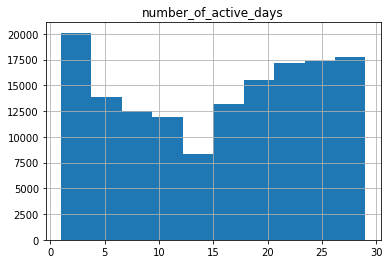

In [56]:
# plot distribution of number of active days per user
active_days_per_user_by_source_df.hist()
plt.show()

In [57]:
# create dataframe with median number of active days per user by traffic source and count of users by traffic source
median_active_days_per_user_by_source_df = active_days_per_user_by_source_df.groupby(['utmSource']).agg(MedianNumActDaysPerUser=('number_of_active_days', 'median'), NumUsers=('number_of_active_days', 'count')).reset_index()

In [58]:
# keep only sources with at least 100 unique users and display metric in descending order
median_active_days_per_user_by_source_df[median_active_days_per_user_by_source_df['NumUsers']>=100].sort_values(by=['MedianNumActDaysPerUser'],ascending=False)

,utmSource,MedianNumActDaysPerUser,NumUsers
43,tapjoy,23.0,347
45,youtube,20.0,458
22,contenthub,20.0,182
4,Grub+Street,20.0,2431
39,salesmanago,20.0,1122
41,shmoop,19.0,6915
37,program,18.0,16493
44,twitter,18.0,5152
27,facebook,18.0,140
36,placement,17.5,264


In [59]:
# format final dataframe for report
median_active_days_per_user_by_source_df = median_active_days_per_user_by_source_df[median_active_days_per_user_by_source_df['NumUsers']>=100].sort_values(by=['MedianNumActDaysPerUser'],ascending=False)
median_active_days_per_user_by_source_df.drop(['NumUsers'],axis=1,inplace=True)
median_active_days_per_user_by_source_df.reset_index(drop=True,inplace=True)
median_active_days_per_user_by_source_df['MedianNumActDaysPerUser'] = median_active_days_per_user_by_source_df['MedianNumActDaysPerUser'].apply(lambda x:int(x))
median_active_days_per_user_by_source_df.rename({'utmSource':'Traffic Source','MedianNumActDaysPerUser':'Median Number of Active Days Per User'},axis=1,inplace=True)

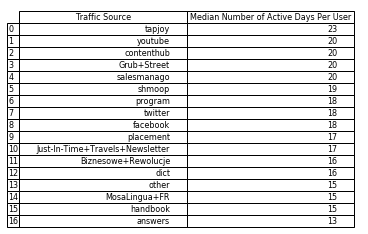

In [60]:
# save dataframe as figure for report
fig, ax = plt.subplots() 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)

tab = table(ax, median_active_days_per_user_by_source_df, loc='upper right')  
tab.auto_set_font_size(False)
tab.set_fontsize(8)
plt.savefig('./plots/MADPU_Table.png', bbox_inches='tight', dpi=300)

# Time Series Analysis & Forecasting: Daily Active Users

We focus on daily active users, one of the metrics measured earlier, and build a forecasting model to predict this metric beyond February 2016.

In [61]:
# create version of DAU dataframe with date as index
DAU_tsa_df = DAU_df.set_index('date')

As discussed above, the DAU series shows an overall positive trend and a 7-day seasonality effect. We can decompose this time series either multiplicatively or additively. Decomposing a time series helps us understand its patterns and features and can be useful in building forecasting models.

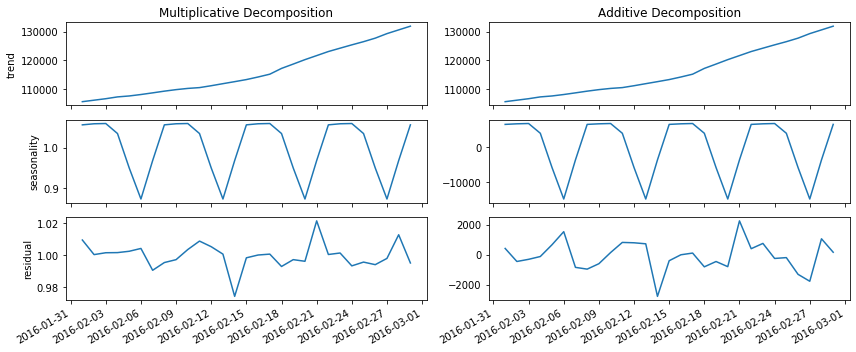

In [62]:
# multiplicative decomposition 
DAU_total_mul_decomp = seasonal_decompose(DAU_tsa_df['total_DAU'], model='multiplicative', extrapolate_trend='freq')

# additive decomposition
DAU_total_add_decomp = seasonal_decompose(DAU_tsa_df['total_DAU'], model='additive', extrapolate_trend='freq')

# plot the components of each decomposition
fig, axs = plt.subplots(3,2, sharex=True, figsize=(12,5))
axs[0,0].plot(DAU_total_mul_decomp.trend)
axs[0,1].plot(DAU_total_add_decomp.trend)
axs[0,0].set_ylabel('trend')   
axs[1,0].plot(DAU_total_mul_decomp.seasonal)
axs[1,1].plot(DAU_total_add_decomp.seasonal)
axs[1,0].set_ylabel('seasonality')
axs[2,0].plot(DAU_total_mul_decomp.resid)
axs[2,1].plot(DAU_total_add_decomp.resid)
axs[2,0].set_ylabel('residual')
        
axs[0,0].set_title('Multiplicative Decomposition')
axs[0,1].set_title('Additive Decomposition')
axs[2,0].get_xaxis().set_major_locator(mdates.DayLocator(interval=3))
axs[2,1].get_xaxis().set_major_locator(mdates.DayLocator(interval=3))

plt.setp(axs[2,0].get_xticklabels(), rotation=30, ha="right")
plt.setp(axs[2,1].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()

We can also extract the trend, seasonality, and residual components. For instance, for the multiplicative decomposition:

In [63]:
# extract components of multiplicative decomposition
# observed = trend*seasonality*residual
DAU_total_compon_df = pd.concat([DAU_total_mul_decomp.trend, DAU_total_mul_decomp.seasonal, DAU_total_mul_decomp.resid, DAU_total_mul_decomp.observed], axis=1)
DAU_total_compon_df.columns = ['trend', 'seasonality', 'residual', 'observed']

In [64]:
DAU_total_compon_df.head()

,trend,seasonality,residual,observed
date,,,,
2016-02-01,105530.948980,1.055884,1.009653,112504.0
2016-02-02,106049.137755,1.058532,1.000540,112317.0
2016-02-03,106567.326531,1.059144,1.001700,113062.0
2016-02-04,107197.571429,1.034539,1.001785,111098.0
2016-02-05,107525.857143,0.950024,1.002622,102420.0


We already know that the DAU series is non-stationary. A rigorous way of testing that is to perform an ADF test and determine whether we can reject the null hypothesis (series is non-stationary) at the 95% confidence level ($\alpha=0.05$):

In [65]:
# ADF test
adf_test = adfuller(DAU_tsa_df['total_DAU'].values, autolag='AIC')

print('ADF Statistic: ',adf_test[0])
print('p-value: ', adf_test[1])
print('Reject null: ', adf_test[1]<=0.05)

ADF Statistic:  0.3608927002421653
p-value:  0.9799720669082845
Reject null:  False


We can also look at the autocorrelation and partial correlation functions. If a series is significantly autocorrelated, we can use past values (lags) to predict future values and build a forecasting model.

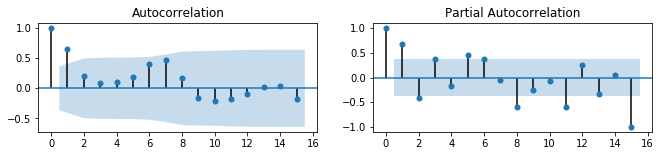

In [66]:
# calculate ACF and PACF
# DAU_acf = acf(DAU_tsa_df['total_DAU'],fft=True)
# DAU_pacf = pacf(DAU_tsa_df['total_DAU'])

# plot ACF and PACF
fig, axes = plt.subplots(1,2,figsize=(11,2))
plot_acf(DAU_tsa_df['total_DAU'], ax=axes[0])
plot_pacf(DAU_tsa_df['total_DAU'], ax=axes[1])
plt.show()

## SARIMA model
We build a SARIMA model to fit the DAU series. We use the auto_arima model from the pmdarima library, which performs stepwise search to find the best set of hyperparameters (p,d,q)x(P,D,Q,m) that minimize AIC, with m=7 in this case since the seasonality is weekly (and we set seasonal=True). The DAU series consists of only 29 observations, so we know that we will not be able to train an extremely good model, as the size of the training set is very limited. However, getting rough estimates and forecasts of DAUs beyond February 2016 might still be a useful insight to understand product growth.

In [67]:
# fit SARIMA model to total_DAU series
sarima_model_total_DAU = pm.auto_arima(DAU_tsa_df[['total_DAU']], start_p=0, start_q=0, test='adf',
                                       seasonal=True, m=7, start_P=0, start_Q=0, D=0,
                                       trace=True, suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=623.400, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=595.776, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=760.960, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=605.802, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=596.670, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=595.655, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=596.490, Time=0.02 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=596.941, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=595.908, Time=0.04 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=618.116, Time=0.05 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=593.835, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=592.251, Time=0.0

In [68]:
# print summary of best model
sarima_model_total_DAU.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   29
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood                -274.287
Date:                             Sat, 17 Oct 2020   AIC                            560.574
Time:                                     17:18:03   BIC                            568.777
Sample:                                          0   HQIC                           563.143
                                              - 29                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9766      0.059     16.611      0.000       0.861       1.092
ma.L1         -0.0156      0.267     -0.058      0.953      -0.540       0.509
ma.L2          0.0346      0.619      0.056      0.955      -1.180       1.249
ar.S.L7        0.9610      0.029     32.647      0.000       0.903       1.019
ma.S.L7       -0.0264      0.418     -0.063      0.950      -0.846       0.793
sigma2      4.015e+06   8.63e-08   4.65e+13      0.000    4.01e+06    4.01e+06
===================================================================================
Ljung-Box (Q):                       19.78   Jarque-Bera (JB):                32.45
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             1.41
Prob(H) (two-sided):                  0.26   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+29. Standard errors may be unstable.
"""

We observe that three coefficients in the model are not significant (MA.L1, MA.L2, MA.S.L7). We can also print and inspect diagnostics plots of the chosen SARIMA model:

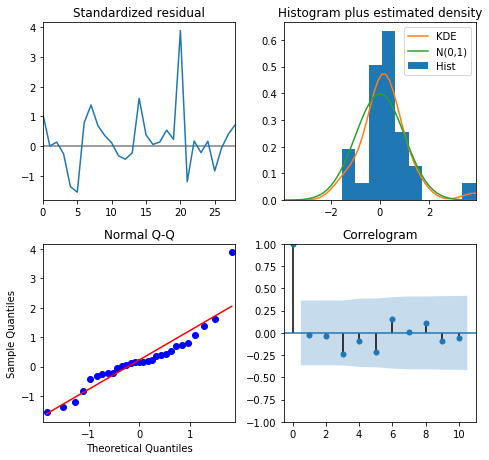

In [69]:
# print diagnostics plots of SARIMA model
sarima_model_total_DAU.plot_diagnostics(figsize=(7,6.5))
plt.tight_layout()
plt.show()

We can qualitatively validate the model by computing the in-sample predictions and see how well the model does:

In [70]:
# create series of in-sample predictions
DAU_in_sample_preds = pd.Series(sarima_model_total_DAU.predict_in_sample()[1:], index=DAU_tsa_df[['total_DAU']][1:].index)

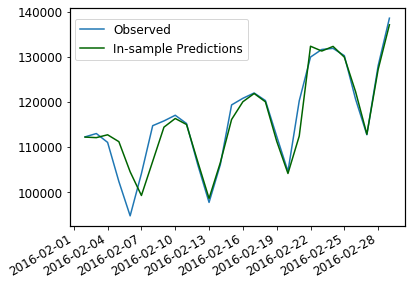

In [71]:
# plot
fig, ax = plt.subplots()

ax.plot(DAU_tsa_df[['total_DAU']][1:], label='Observed')
ax.plot(DAU_in_sample_preds, color='darkgreen', label='In-sample Predictions')

ax.legend(fontsize=12,bbox_to_anchor=(0.55,0.98))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=3))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
plt.show()

We can also compute the RMSE for the in-sample predictions:

In [72]:
# RMSE
np.sqrt(np.mean((DAU_tsa_df['total_DAU'][1:]-DAU_in_sample_preds)**2))

3548.220863751693

The obtained model seems to be doing a fairly good job at in-sample predictions. Finally, we can use it to make future predictions of daily active users, with the caveat that in a real-world scenario additional data is certainly needed to improve the reliability and accuracy of the model.

In [73]:
# number of days to forecast
n_days = 14
pred, CI_pred = sarima_model_total_DAU.predict(n_periods=n_days, return_conf_int=True)
pred_date_index = pd.date_range(DAU_tsa_df[['total_DAU']].index[-1], periods = n_days+1, freq='D')

# prepend last value in total_DAU series to forecast series
pred = np.insert(pred, 0, DAU_tsa_df['total_DAU'][-1], axis=0)
CI_pred = np.insert(CI_pred, 0, [DAU_tsa_df['total_DAU'][-1],DAU_tsa_df['total_DAU'][-1]], axis=0)

# create forecasted time series
pred_series = pd.Series(pred, index=pred_date_index)
lower_CI_pred_series = pd.Series(CI_pred[:, 0], index=pred_date_index)
upper_CI_pred_series = pd.Series(CI_pred[:, 1], index=pred_date_index)

In [74]:
# create forecasted dataframe
DAU_forecast_df = pd.concat([lower_CI_pred_series[1:].astype(int),pred_series[1:].astype(int),upper_CI_pred_series[1:].astype(int)],axis=1)
DAU_forecast_df.rename({0:'Lower Forecast',1:'Forecast',2:'Upper Forecast'},axis=1,inplace=True)

In [75]:
DAU_forecast_df

,Lower Forecast,Forecast,Upper Forecast
2016-03-01,136009,139936,143863
2016-03-02,134472,139918,145365
2016-03-03,131399,138052,144706
2016-03-04,120871,128500,136129
2016-03-05,112192,120647,129102
2016-03-06,125875,135049,144223
2016-03-07,135057,144868,154679
2016-03-08,133748,145838,157928
2016-03-09,131662,145554,159447
2016-03-10,128030,143502,158974


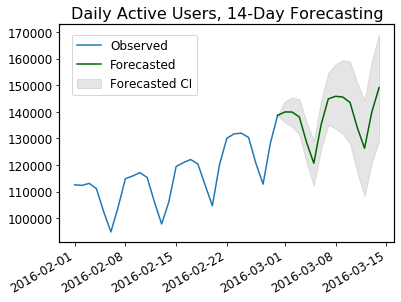

In [76]:
# plot observed series and forecasts
fig, ax = plt.subplots()

ax.plot(DAU_tsa_df[['total_DAU']], label='Observed')
ax.plot(pred_series, color='darkgreen', label='Forecasted')
ax.fill_between(lower_CI_pred_series.index, lower_CI_pred_series, upper_CI_pred_series, color='k', alpha=0.1,
                label='Forecasted CI')
plt.title('Daily Active Users, ' + str(n_days) + '-Day Forecasting', fontdict = {'fontsize':16})

ax.legend(fontsize=12,bbox_to_anchor=(0.43,0.98))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.show()

## Decomposition-based SARIMA model
Another approach to building a forecasting model is to use the multiplicative decomposition of the DAU series obtained above and build SARIMA models for each component (trend, seasonality, and residuals). The final forecasts will be obtained by multiplying the forecasts from each component model.

### trend

In [77]:
sarima_model_trend_DAU = pm.auto_arima(DAU_total_compon_df[['trend']], start_p=0, start_q=0, test='adf',
                                       seasonal=True, start_P=0, start_Q=0,
                                       trace=True, suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=381.316, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=383.242, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=383.229, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=385.206, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=383.008, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.083 seconds


In [78]:
trend_pred, trend_CI_pred = sarima_model_trend_DAU.predict(n_periods=n_days, return_conf_int=True)

trend_pred = np.insert(trend_pred, 0, DAU_total_compon_df['trend'][-1], axis=0)
trend_CI_pred = np.insert(trend_CI_pred, 0, [DAU_total_compon_df['trend'][-1],DAU_total_compon_df['trend'][-1]], axis=0)

trend_pred_series = pd.Series(trend_pred, index=pred_date_index)
trend_lower_CI_pred_series = pd.Series(trend_CI_pred[:, 0], index=pred_date_index)
trend_upper_CI_pred_series = pd.Series(trend_CI_pred[:, 1], index=pred_date_index)

trend_df = pd.concat([trend_lower_CI_pred_series[1:],trend_pred_series[1:],trend_upper_CI_pred_series[1:]],axis=1)
trend_df.rename({0:'Lower Forecast',1:'Forecast',2:'Upper Forecast'},axis=1,inplace=True)

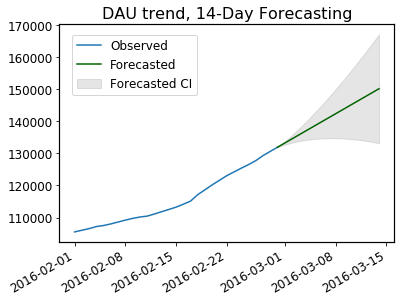

In [79]:
fig, ax = plt.subplots()
ax.plot(DAU_total_compon_df[['trend']], label='Observed')
ax.plot(trend_pred_series, color='darkgreen', label='Forecasted')
ax.fill_between(trend_lower_CI_pred_series.index, trend_lower_CI_pred_series, trend_upper_CI_pred_series, color='k', alpha=0.1,
                label='Forecasted CI')
plt.title('DAU trend, ' + str(n_days) + '-Day Forecasting', fontdict = {'fontsize':16})

ax.legend(fontsize=12,bbox_to_anchor=(0.43,0.98))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.show()

### seasonality

In [80]:
sarima_model_season_DAU = pm.auto_arima(DAU_total_compon_df[['seasonality']], start_p=0, start_q=0, test='adf',
                                        seasonal=True, m=7, start_P=0, start_Q=0, D=0,
                                        trace=True, suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-71.476, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=84.535, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-77.893, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=-98.849, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=-171.564, Time=0.18 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(2,0,1)[7

In [81]:
season_pred, season_CI_pred = sarima_model_season_DAU.predict(n_periods=n_days, return_conf_int=True)

season_pred = np.insert(season_pred, 0, DAU_total_compon_df['seasonality'][-1], axis=0)
season_CI_pred = np.insert(season_CI_pred, 0, [DAU_total_compon_df['seasonality'][-1],DAU_total_compon_df['seasonality'][-1]], axis=0)

season_pred_series = pd.Series(season_pred, index=pred_date_index)
season_lower_CI_pred_series = pd.Series(season_CI_pred[:, 0], index=pred_date_index)
season_upper_CI_pred_series = pd.Series(season_CI_pred[:, 1], index=pred_date_index)

season_df = pd.concat([season_lower_CI_pred_series[1:],season_pred_series[1:],season_upper_CI_pred_series[1:]],axis=1)
season_df.rename({0:'Lower Forecast',1:'Forecast',2:'Upper Forecast'},axis=1,inplace=True)

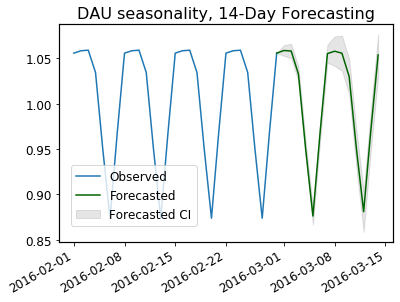

In [82]:
fig, ax = plt.subplots()
ax.plot(DAU_total_compon_df[['seasonality']], label='Observed')
ax.plot(season_pred_series, color='darkgreen', label='Forecasted')
ax.fill_between(season_lower_CI_pred_series.index, season_lower_CI_pred_series, season_upper_CI_pred_series, color='k', alpha=0.1,
                label='Forecasted CI')
plt.title('DAU seasonality, ' + str(n_days) + '-Day Forecasting', fontdict = {'fontsize':16})

ax.legend(fontsize=12,bbox_to_anchor=(0.43,0.38))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.show()

### residuals

In [83]:
sarima_model_resid_DAU = pm.auto_arima(DAU_total_compon_df[['residual']], start_p=0, start_q=0, test='adf',
                                       seasonal=True, start_P=0, start_Q=0, 
                                       trace=True, suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-168.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-171.829, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-170.517, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-170.240, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-177.279, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-177.505, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-173.065, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-175.131, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-175.551, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-175.215, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-174.276, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-174.359, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-

In [84]:
resid_pred, resid_CI_pred = sarima_model_resid_DAU.predict(n_periods=n_days, return_conf_int=True)

resid_pred = np.insert(resid_pred, 0, DAU_total_compon_df['residual'][-1], axis=0)
resid_CI_pred = np.insert(resid_CI_pred, 0, [DAU_total_compon_df['residual'][-1],DAU_total_compon_df['residual'][-1]], axis=0)

resid_pred_series = pd.Series(resid_pred, index=pred_date_index)
resid_lower_CI_pred_series = pd.Series(resid_CI_pred[:, 0], index=pred_date_index)
resid_upper_CI_pred_series = pd.Series(resid_CI_pred[:, 1], index=pred_date_index)

resid_df = pd.concat([resid_lower_CI_pred_series[1:],resid_pred_series[1:],resid_upper_CI_pred_series[1:]],axis=1)
resid_df.rename({0:'Lower Forecast',1:'Forecast',2:'Upper Forecast'},axis=1,inplace=True)

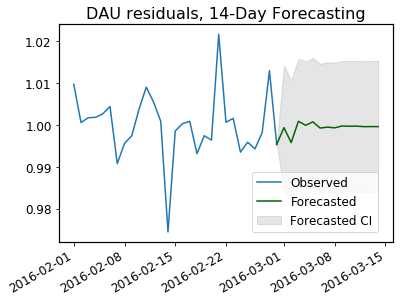

In [85]:
fig, ax = plt.subplots()
ax.plot(DAU_total_compon_df[['residual']], label='Observed')
ax.plot(resid_pred_series, color='darkgreen', label='Forecasted')
ax.fill_between(resid_lower_CI_pred_series.index, resid_lower_CI_pred_series, resid_upper_CI_pred_series, color='k', alpha=0.1,
                label='Forecasted CI')
plt.title('DAU residuals, ' + str(n_days) + '-Day Forecasting', fontdict = {'fontsize':16})

ax.legend(fontsize=12,bbox_to_anchor=(0.56,0.35))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.show()

### trend * seasonality * residual

In [86]:
# create series of in-sample predictions
# we start generating in-sample predictions from the 3rd observation
# because the trend SARIMA model has d=2 (2nd differencing)
DAU_trend_in_sample_preds = pd.Series(sarima_model_trend_DAU.predict_in_sample()[2:], index=DAU_total_compon_df[['trend']][2:].index)
DAU_season_in_sample_preds = pd.Series(sarima_model_season_DAU.predict_in_sample()[2:], index=DAU_total_compon_df[['seasonality']][2:].index)
DAU_resid_in_sample_preds = pd.Series(sarima_model_resid_DAU.predict_in_sample()[2:], index=DAU_total_compon_df[['residual']][2:].index)

DAU_mul_decomp_in_sample_preds = DAU_trend_in_sample_preds*DAU_season_in_sample_preds*DAU_resid_in_sample_preds

In [87]:
forecast_comp_series = trend_pred_series*resid_pred_series*season_pred_series
forecast_comp_lower_CI_series = trend_lower_CI_pred_series*season_lower_CI_pred_series*resid_lower_CI_pred_series
forecast_comp_upper_CI_series = trend_upper_CI_pred_series*season_upper_CI_pred_series*resid_upper_CI_pred_series

In [88]:
# create forecasted (decomposition-based) dataframe
DAU_forecast_comp_df = pd.concat([forecast_comp_lower_CI_series[1:].astype(int),forecast_comp_series[1:].astype(int),forecast_comp_upper_CI_series[1:].astype(int)],axis=1)
DAU_forecast_comp_df.rename({0:'Lower Forecast',1:'Forecast',2:'Upper Forecast'},axis=1,inplace=True)

In [89]:
DAU_forecast_comp_df

,Lower Forecast,Forecast,Upper Forecast
2016-03-01,137555,140963,144416
2016-03-02,137359,141756,146242
2016-03-03,135237,140404,145697
2016-03-04,124377,130246,136287
2016-03-05,114843,121370,128120
2016-03-06,127144,135331,143808
2016-03-07,138604,148755,159279
2016-03-08,138055,150480,163475
2016-03-09,137342,151609,166606
2016-03-10,133774,149242,165535


## Comparison between models

In [90]:
# RMSE for global SARIMA model
np.sqrt(np.mean((DAU_tsa_df['total_DAU'][1:]-DAU_in_sample_preds)**2))

3548.220863751693

In [91]:
# RMSE for decomposition-based SARIMA model
np.sqrt(np.mean((DAU_tsa_df['total_DAU'][2:]-DAU_mul_decomp_in_sample_preds)**2))

1849.3327557277505

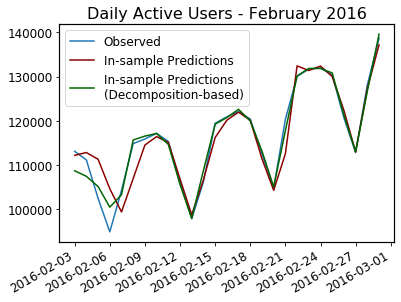

In [92]:
# plot observed vs in-sample predictions from the two models
fig, ax = plt.subplots()

ax.plot(DAU_total_compon_df[['observed']][2:], label='Observed')
ax.plot(DAU_in_sample_preds[1:], color='darkred', label='In-sample Predictions')
ax.plot(DAU_mul_decomp_in_sample_preds, color='darkgreen',
        label='In-sample Predictions\n(Decomposition-based)')

ax.legend(fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=3))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.title('Daily Active Users - February 2016', fontdict = {'fontsize':16})
plt.savefig('./plots/DAU_FC_In_Sample.png', bbox_inches='tight', dpi=300)
plt.show()

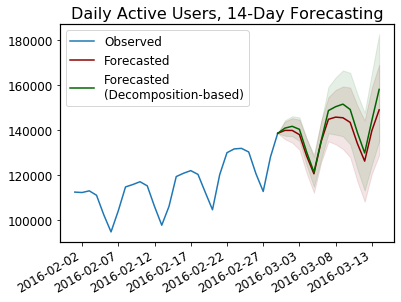

In [93]:
# plot observed and forecasts from the two models
fig, ax = plt.subplots()

ax.plot(DAU_total_compon_df[['observed']], label='Observed')

ax.plot(pred_series, color='darkred', label='Forecasted')
ax.fill_between(lower_CI_pred_series.index, lower_CI_pred_series, upper_CI_pred_series, color='darkred',
                alpha=0.1)

ax.plot(forecast_comp_series, color='darkgreen', label='Forecasted\n(Decomposition-based)')
ax.fill_between(forecast_comp_lower_CI_series.index, forecast_comp_lower_CI_series, forecast_comp_upper_CI_series,
                alpha=0.1, color='darkgreen')

ax.legend(fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=5))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.title('Daily Active Users, ' + str(n_days) + '-Day Forecasting', fontdict = {'fontsize':16})
plt.savefig('./plots/DAU_FC.png', bbox_inches='tight', dpi=300)
plt.show()